**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [262]:
import sympy as sm
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.optimize import minimize, fixed_point, root
%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

#### Question 1

Procedure: 

1. Set parameters
2. Define functions
3. Sub in constraint (C)
4. Calc derivative dV/dL and find FOC
5. Evaluate function for G=1 and G=2
6. Verify the solution is correct

In [315]:
sm.init_printing()

# Define symbols
L, w, tau, G, kappa, alpha, nu, wtilde = sm.symbols('L w tau G kappa alpha nu wtilde')

# Set parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
tau = 0.3
wtilde = 0.7

# utility function
C = kappa + (1 - tau) * w * L
V = sm.ln(C**alpha * G**(1 - alpha)) - nu * L**2 / 2

# Substitute in budget_cons and wtilde

budget_constraint = sm.Eq(C, kappa + (1-tau)*w*L)
V_cons = sm.ln((kappa + (1-tau)*w*L)**alpha * G**(1 - alpha)) - nu * L**2 / 2


# Calculate derivative
Vprime = sm.diff(V_cons, L)

# Find the maximum
sol = sm.solve(Vprime, L)


# Evaluate for G=1 and G=2
G_values = [1, 2]
sol_G = {g: [s.subs(G, g) for s in sol] for g in G_values}

print('Optimized labor hours for G=1 and G=2:')
display(sol_G)




Optimized labor hours for G=1 and G=2:


{1: [-16.730221655767, 15.3016502271956], 2: [-16.730221655767, 15.30165022719
56]}

We're not interested in negative solutions to labor supply, so we look at the second elements:

In [212]:
# Verifying solution:


Lwtilde = (-kappa + sm.sqrt(kappa**2 + 4 * (alpha / nu) * wtilde**2)) / (2 * wtilde)


if sol_G[1][1].equals(Lwtilde):
    print(f'The expressions are equal')
else:
    print(f'The expressions are not equal')



The expressions are equal


The expression is verified as correct.

-------------

#### Question 2

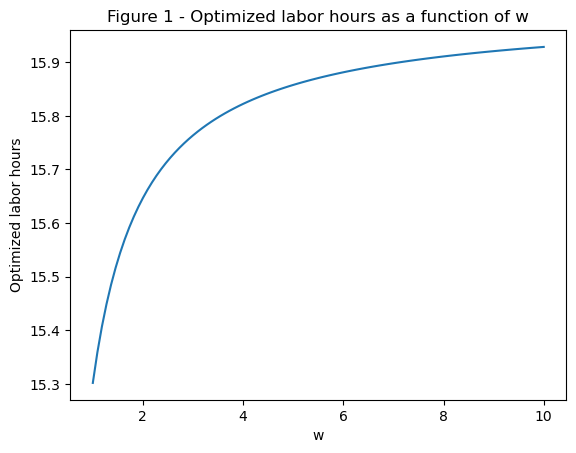

In [238]:

# Define symbols
L, w, tau, G, kappa, alpha, nu, wtilde = sm.symbols('L w tau G kappa alpha nu wtilde')

# Set parameters
alpha_val = 0.5
kappa_val = 1.0
nu_val = 1 / (2 * 16**2)
tau_val = 0.3
wtilde_val = 0.7

# Utility function
C = kappa + (1 - tau) * w * L
V = sm.ln(C**alpha * G**(1 - alpha)) - nu * L**2 / 2

# Substitute in budget constraint
budget_constraint = sm.Eq(C, kappa + (1-tau)*w*L)
V_cons = sm.ln((kappa + (1-tau)*w*L)**alpha * G**(1 - alpha)) - nu * L**2 / 2

# Calculate derivative
Vprime = sm.diff(V_cons, L)

# Find the maximum
sol1 = sm.solve(Vprime, L)

# Vary w and evaluate
w_values = np.linspace(1, 10, 100)  
results = {}


results= []
for w_val in w_values:
    sol_G1 = [s.subs({alpha: alpha_val, kappa: kappa_val, nu: nu_val, w: w_val, tau: tau_val}) for s in sol1]
    results.append(sol_G1[0])  # Assuming there's only one solution

# Plot the results

plt.plot(w_values, results)

plt.xlabel('w')
plt.ylabel('Optimized labor hours')
plt.title('Figure 1 - Optimized labor hours as a function of w')
plt.show()

Optimal labor supply is a convex and decreasing function of w, implying diminishing utility returns to labor hours

--------------


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


This looks like a complex problem with an implicitly defined L, so I rethink my approach from symbolic to explicitly numeric.

Plan:

1. Set parameters
2. Define functions but this time not via sympy
3. Find a method that can handle functions involving variables implicitly defined (fixed-point iteration)
4. Test optimization
5. Let $\tau$ vary
6. Plot the results

In [272]:
# Setting up and testing
# Set parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
tau = 0.3

def utility(L, L_star, alpha, kappa, nu, w, tau):
    '''Worker Utility function 
    args; L: Labor, L_star: optimal labor, Model parameters'''
    C = kappa + (1 - tau) * w * L
    G = tau * w * L_star * ((1 - tau) * w)
    V = np.log(C**alpha * G**(1 - alpha)) - nu * L**2 / 2
    return -V  # Return negative utility for minimization


def G_func(L_star):
    '''Optimizer used to find optimal Labor'''
    L_start = L_star
    res = minimize(utility, L_start, args=(L_star, alpha, kappa, nu, w, tau), method='Nelder-Mead')
    return res.x[0]

# Initial guess for L_star
L_star_start = 0.5

# Find fixed point func(x0)==x0
L_star = fixed_point(G_func, L_star_start, method="iteration")
print(f"The solution to the maximization problem is L* = {L_star}")

The solution to the maximization problem is L* = 15.30166015625003


The solution is the same as before, which is not catastrophic, but I have no real intuition as to whether it is correct, so I soldier on. 

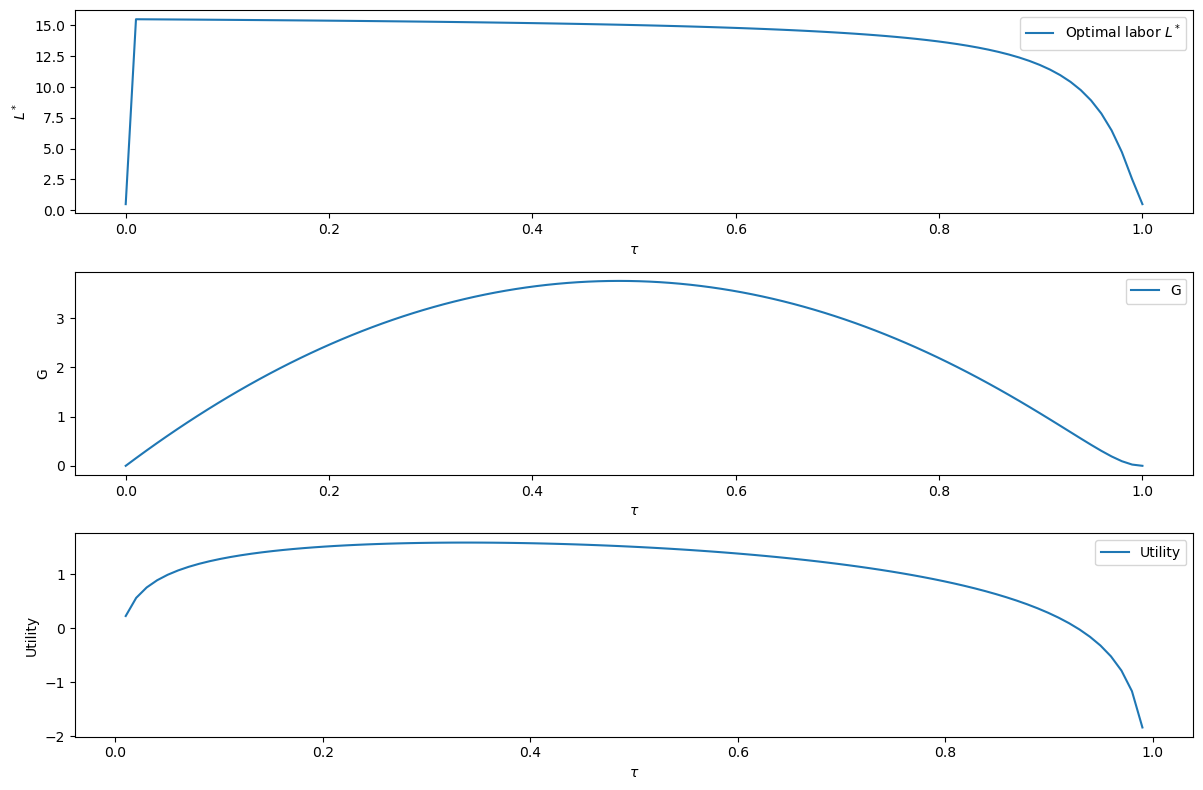

In [275]:
# Set parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1


# New utility function cuz the old had some issues with warnings due to division by zero
def utility(L, L_star, alpha, kappa, nu, w, tau):
    C = kappa + (1 - tau) * w * L
    G = tau * w * L_star * ((1 - tau) * w)
    if G <= 0:  # Check if G is less than or equal to zero
        return -np.inf  # Return a very large negative utility
    else:
        V = np.log(np.maximum(G, 1e-10)**(1 - alpha) * C**alpha) - nu * L**2 / 2
        return -V

# New G-func to accomodate tau
def G_func(L_star, tau):
    L_start = L_star
    res = minimize(utility, L_start, args=(L_star, alpha, kappa, nu, w, tau), method='Nelder-Mead')
    return res.x[0]

# Generate a grid of tau values
tau_values = np.linspace(0, 1, 100)

# Initialize arrays to store the results
L_star_values = np.empty_like(tau_values)
G_values = np.empty_like(tau_values)
utility_values = np.empty_like(tau_values)

# For each tau, solve for L_star and calculate G and utility
for i, tau in enumerate(tau_values):
    # Find the optimal labor
    L_star = fixed_point(G_func, 0.5, args=(tau,), method="iteration")
    
    # Compute G
    G = tau * w * L_star * ((1 - tau) * w)
    
    # Compute the utility
    U = -utility(L_star, L_star, alpha, kappa, nu, w, tau) 
    
    # Store the results
    L_star_values[i] = L_star
    G_values[i] = G
    utility_values[i] = U

# Create the plots
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(tau_values, L_star_values, label="Optimal labor $L^*$")
plt.xlabel("$\\tau$")
plt.ylabel("$L^*$")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(tau_values, G_values, label="G")
plt.xlabel("$\\tau$")
plt.ylabel("G")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tau_values, utility_values, label="Utility")
plt.xlabel("$\\tau$")
plt.ylabel("Utility")
plt.legend()

plt.tight_layout()
plt.show()

These results look in line with what could be expected. Labor is convex with diminishing returns due to disutility to labor. However, the form of the $\nu$ term makes me think it ought to  be continuously convex. Perhaps it is due to the nature of the fixed-point optimization.

Government consumption looks like the Laffer-curve, also as expected. 

--------------------------------

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

1. Set parameters, define func.
2. Reuse fixed-point optimizer
3. Instead of iterating tau, write function that optimizes tau based on the FP and utility
4. Optimize

In [276]:

# Set parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1

def utility(L, L_star, alpha, kappa, nu, w, tau):
    C = kappa + (1 - tau) * w * L
    G = tau * w * L_star * ((1 - tau) * w)
    if G <= 0:  # Check if G is less than or equal to zero
        return -np.inf  # Return a very large negative utility
    else:
        V = np.log(np.maximum(G, 1e-10)**(1 - alpha) * C**alpha) - nu * L**2 / 2
        return -V


def G_func(L_star, tau):
    L_start = L_star
    res = opt.minimize(utility, L_start, args=(L_star, alpha, kappa, nu, w, tau), method='Nelder-Mead')
    return res.x[0]

# Define function to find the maximum utility for a given tau
def utility_max(tau):
    # Find the optimal labor
    L_star = fixed_point(G_func, 0.5, args=(tau,), method="iteration")
    
    # Compute the utility
    U = -utility(L_star, L_star, alpha, kappa, nu, w, tau)  
    
    return -U  

# Initial guess for tau
tau_start = 0.5

# Find the tau that maximizes utility
res = opt.minimize(utility_max, tau_start, bounds=[(0, 1)], method='Nelder-Mead')
tau_star = res.x[0]

print(f"The value of tau that maximizes utility is tau* = {tau_star}")

The value of tau that maximizes utility is tau* = 0.3378906249999999


---------------

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

Plan: 

1. Set Parameters
2. Define new utility function
3. Solve max. problem dutility/dL for given values of G and tau
4. Define function that solves for G with L_star as input
5. Solve it

In [261]:
# FIRST SET
# Parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
rho = 1.001
sigma = 1.001
epsilon = 1.0

# Utility function
def utility(L, tau, G, w, alpha, kappa, nu, rho, sigma, epsilon):
    C = kappa + (1 - tau) * w * L
    term1 = alpha * (C**((sigma - 1) / sigma))
    term2 = (1 - alpha) * (G**((sigma - 1) / sigma))
    utility = ((term1 + term2)**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
    return -utility  

# Solving the maximization problem for given tau and G
def solve_worker(tau, G):
    res = minimize(utility, 0.5, args=(tau, G, w, alpha, kappa, nu, rho, sigma, epsilon), bounds=[(0, 24)])
    L_star = res.x[0]
    return L_star

In [264]:
# Equilibrium condition
def equilibrium(G, tau):
    L_star = solve_worker(tau, G)
    return G - tau * w * L_star * ((1 - tau) * w)

# Finding the equilibrium G
res = root(equilibrium, 0.5, args=(tau_star))  # We start with an initial guess of 0.5 for G
G_star = res.x[0]

print(f"The value of G that solves the first set equilibrium condition is G* = {G_star}")

The value of G that solves the first set equilibrium condition is G* = 0.5000105005545925


In [265]:
# SECOND SET

# Parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
rho = 1.5
sigma = 1.5
epsilon = 1.0

# Utility function
def utility(L, tau, G, w, alpha, kappa, nu, rho, sigma, epsilon):
    C = kappa + (1 - tau) * w * L
    term1 = alpha * (C**((sigma - 1) / sigma))
    term2 = (1 - alpha) * (G**((sigma - 1) / sigma))
    utility = ((term1 + term2)**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
    return -utility  

# Solving the maximization problem for given tau and G
def solve_worker(tau, G):
    res = minimize(utility, 0.5, args=(tau, G, w, alpha, kappa, nu, rho, sigma, epsilon), bounds=[(0, 24)])
    L_star = res.x[0]
    return L_star

In [266]:
# Equilibrium condition
def equilibrium(G, tau):
    L_star = solve_worker(tau, G)
    return G - tau * w * L_star * ((1 - tau) * w)

# Finding the equilibrium G
res = root(equilibrium, 0.5, args=(tau_star))  # We start with an initial guess of 0.5 for G
G_star = res.x[0]

print(f"The value of G that solves the second set equilibrium condition is G* = {G_star}")

The value of G that solves the second set equilibrium condition is G* = 2.4808216248742627


--------------

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [285]:
# Set one Parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
rho = 1.001
sigma = 1.001
epsilon = 1.0

def utility(L, tau, G, w, alpha, kappa, nu, rho, sigma, epsilon):
   
    if G <= 0 or sigma <= 1:  # Check if G is less than or equal to zero or sigma is less than or equal to 1
        
        return np.inf  # Return a yuge utility (because we're minimizing)
    else:
        C = kappa + (1 - tau) * w * L
        term1 = alpha * (C**((sigma - 1) / sigma))
        term2 = (1 - alpha) * (G**((sigma - 1) / sigma))
        utility = ((term1 + term2)**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
        return -utility  

# Solving the worker's problem for given tau and G
def solve_worker(tau, G):
    res = minimize(utility, 0.5, args=(tau, G, w, alpha, kappa, nu, rho, sigma, epsilon), bounds=[(0, 24)])
    L_star = res.x[0]
    return L_star

# Equilibrium condition
def equilibrium(G, tau):
    L_star = solve_worker(tau, G)
    return G - tau * w * L_star * ((1 - tau) * w)

def utility_max(tau):
    # Find the equilibrium G for this tau
    G_res = root(equilibrium, 0.5, args=(tau))
    G_star = G_res.x[0]
    
    # Find the optimal labor
    L_star = solve_worker(tau, G_star)
    
    # Compute the utility
    U = -utility(L_star, tau, G_star, w, alpha, kappa, nu, rho, sigma, epsilon)  
    
    return -U, G_star, L_star  # Return negative utility for minimization, G_star and L_star

# Find the tau that maximizes utility
res = minimize(lambda tau: utility_max(tau)[0], tau_start, bounds=[(0, 1)], method='Nelder-Mead')
tau_star_social = res.x[0]
max_utility, G_star, L_star = utility_max(tau_star_social)

print(f"The socially optimal tax rate that maximizes worker utility is tau* = {tau_star_social}")
print(f"The maximum utility is {max_utility}")
print(f"The corresponding G* = {G_star}")
print(f"The corresponding L* = {L_star}")

The socially optimal tax rate that maximizes worker utility is tau* = 0.049999999953433474
The maximum utility is 999.0101367862959
The corresponding G* = 0.7355552726905789
The corresponding L* = 15.48506156438835


In [286]:
# Set two Parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1
rho = 1.5
sigma = 1.5
epsilon = 1.0

def utility(L, tau, G, w, alpha, kappa, nu, rho, sigma, epsilon):
   
    if G <= 0 or sigma <= 1:  # Check if G is less than or equal to zero or sigma is less than or equal to 1
        
        return np.inf  # Return a yuge utility (because we're minimizing)
    else:
        C = kappa + (1 - tau) * w * L
        term1 = alpha * (C**((sigma - 1) / sigma))
        term2 = (1 - alpha) * (G**((sigma - 1) / sigma))
        utility = ((term1 + term2)**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
        return -utility  

# Solving the worker's problem for given tau and G
def solve_worker(tau, G):
    res = minimize(utility, 0.5, args=(tau, G, w, alpha, kappa, nu, rho, sigma, epsilon), bounds=[(0, 24)])
    L_star = res.x[0]
    return L_star

# Equilibrium condition
def equilibrium(G, tau):
    L_star = solve_worker(tau, G)
    return G - tau * w * L_star * ((1 - tau) * w)

def utility_max(tau):
    # Find the equilibrium G for this tau
    G_res = root(equilibrium, 0.5, args=(tau))
    G_star = G_res.x[0]
    
    # Find the optimal labor
    L_star = solve_worker(tau, G_star)
    
    # Compute the utility
    U = -utility(L_star, tau, G_star, w, alpha, kappa, nu, rho, sigma, epsilon) 
    
    return -U, G_star, L_star  # Return negative utility for minimization, G_star and L_star

# Find the tau that maximizes utility
res = minimize(lambda tau: utility_max(tau)[0], tau_start, bounds=[(0, 1)], method='Nelder-Mead')
tau_star_social = res.x[0]
max_utility, G_star, L_star = utility_max(tau_star_social)

print(f"The socially optimal tax rate that maximizes worker utility is tau* = {tau_star_social}")
print(f"The maximum utility is {max_utility}")
print(f"The corresponding G* = {G_star}")
print(f"The corresponding L* = {L_star}")

The socially optimal tax rate that maximizes worker utility is tau* = 0.2765624999999998
The maximum utility is 1.0255326783528171
The corresponding G* = 2.2492757535236385
The corresponding L* = 11.242124683538076


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [334]:
# Set Parameters
eta = 0.5
w = 1.0
kappa_values = [1,2]

def neg_profit(l, kappa):
    # Define the negative profit function
    return -(kappa * l**0.5 - w * l)

# Dictionary to store solutions
sol_l = {}

# Iterating over kappa_values, calculate the optimal number of hairdressers and store in the dictionary
for kappa in kappa_values:
    result = minimize(neg_profit, x0=[1], args=(kappa,), bounds=[(0, None)], method='Nelder-Mead')

    # Store optimal l in dictionary
    sol_l[kappa] = result.x[0]

# Print the solutions
for kappa, opt_l in sol_l.items():
    print("The optimal number of hairdressers for demand shock", kappa, "is", opt_l)

The optimal number of hairdressers for demand shock 1 is 0.24999999999999933
The optimal number of hairdressers for demand shock 2 is 1.0


In [339]:
# Verifying the results to within a certain tolerance, cuz it certainly looks like the answer is 0.25

epsilon = 1e-7

l_t_1 = (((1-eta)*1)/w)**(1/eta) # The expression to check, with kappa=1 

if abs(sol_l[1]-l_t_1) < epsilon: # The optimized l, kappa = 1 
    print(f'The expressions are equal')
else:
    print(f'The expressions are not equal')

l_t_2 = (((1-eta)*2)/w)**(1/eta) # Expression to check, kappa = 2

if abs(sol_l[2]-l_t_2) < epsilon:
    print(f'The expressions are equal')
else:
    print(f'The expressions are not equal')

The expressions are equal
The expressions are equal


The expression has been verified numerically.

--------------

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [340]:
import numpy as np
from scipy.stats import norm

# Set Parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
eta = 0.5
w = 1.0
K = 10000  # Number of random shock series
T = 120  # Number of months

# Function to calculate profits given kappa and l
def calculate_profits(kappa, l, prev_l):
    return R * (kappa * l**(1 - eta) - w * l - iota * (l != prev_l))

# Function to calculate l given kappa
def calculate_l(kappa):
    return ((1 - eta) * kappa / w) ** (1 / eta)

# Initialize profits
profits = np.zeros(K)

# Loop over K random shock series
for k in range(K):
    # Initialize kappa and l
    kappa = np.ones(T + 1)  # Plus 1 because kappa starts from t = -1
    l = np.zeros(T + 1)  # Plus 1 because l starts from t = -1

    # Generate random shock series
    epsilon = norm.rvs(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=T)

    # Update kappa and l for each month
    for t in range(T):
        kappa[t + 1] = np.exp(rho * np.log(kappa[t]) + epsilon[t])
        l[t + 1] = calculate_l(kappa[t + 1])

    # Calculate profits for this shock series and add to total profits
    for t in range(T):
        profits[k] += calculate_profits(kappa[t + 1], l[t + 1], l[t])

# Calculate and print H
H = np.mean(profits)
print(f'The expected value of the salon, H, is {H}.')

The expected value of the salon, H, is 29.153475743729935.


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [10]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [11]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [12]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [292]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

Iteration 0: Initial guess is [405.21581986 499.15996066] with function value 103.98680450300888
Iteration 1: Initial guess is [-467.96094783  347.4655321 ] with function value 84.01112521232224
Iteration 2: Initial guess is [591.86983056 494.19568617] with function value 148.83077724412402
Iteration 3: Initial guess is [-324.53120647 -566.23835574] with function value 105.67514137851178
Iteration 4: Initial guess is [-252.65433473  395.14537648] with function value 55.22943654930241
Iteration 5: Initial guess is [ -54.78295971 -370.04475085] with function value 34.67440438631283
Iteration 6: Initial guess is [ 118.3076318  -237.03351951] with function value 17.22413884420249
Iteration 7: Initial guess is [114.2925112  302.72023051] with function value 25.991757568623516
Iteration 8: Initial guess is [  68.07413168 -326.25363666] with function value 15.58761832219937
Iteration 9: Initial guess is [-384.68365453  469.80998458] with function value 92.09676029820574
Iteration 10: Initial 

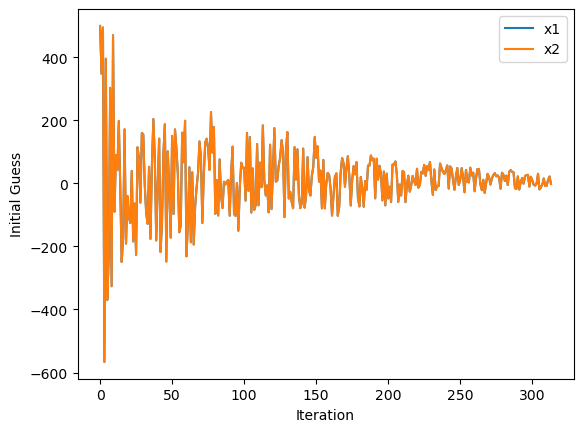

In [299]:
# chi^k function (C.)
def chi(k, K_warmup):
    return 0.50 * (2 / (1 + np.exp((k - K_warmup) / 100)))

def global_optimizer(func, bounds, K_warmup, K_max, tolerance):
    x_star = np.zeros(len(bounds)) # Zero vector
    min_func_value = np.inf  # Set to infinity initially for comparison
    initial_guesses = [] 
    for k in range(K_max): # for-loop running for K_max iterations
        x_k = np.random.uniform(bounds[:, 0], bounds[:, 1]) # Draw random guess (A.)
        if k >= K_warmup: 
            x_k0 = chi(k, K_warmup) * x_k + (1 - chi(k, K_warmup)) * x_star # I am mystified (D.) 
        else:
            x_k0 = x_k # (B.)
        initial_guesses.append(x_k0) # Append x_k0 to initial guesses lsit
        result = minimize(func, x_k0, method='BFGS', tol=tolerance) # Optimize (E.)
        if k < 10 or result.fun < min_func_value:  # Print for first 10 iterations or if the result is improved
            print(f'Iteration {k}: Initial guess is {x_k0} with function value {result.fun}')
        if result.fun < min_func_value:  # Keep track of the minimum function value found so far (F.)
            min_func_value = result.fun
            x_star = result.x
        if func(x_star) < tolerance: # Stop The Count! (G.)
            break
    return x_star, initial_guesses # 4.

# Defining bounds, tolerances and iterations
bounds = np.array([[-600, 600], [-600, 600]])
tolerance = 1e-8
K_warmup = 10
K_max = 1000

# Executing the global optimizer
x_star, initial_guesses = global_optimizer(griewank, bounds, K_warmup, K_max, tolerance)

# Visualizing how the initial guesses evolve
initial_guesses = np.array(initial_guesses)
plt.plot(initial_guesses[:, 1], label='x1')
plt.plot(initial_guesses[:, 1], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial Guess')
plt.legend()
plt.show()

-----------

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

Iteration 0: Initial guess is [ 352.44981892 -196.6613792 ] with function value 40.47963577326804
Iteration 1: Initial guess is [550.03733732 169.03980596] with function value 81.3077407323784
Iteration 2: Initial guess is [ 29.34379117 108.37016458] with function value 2.632673762722763
Iteration 3: Initial guess is [564.48440482 253.21320168] with function value 90.19160362851021
Iteration 4: Initial guess is [  -7.04221388 -415.37134663] with function value 43.56989214824688
Iteration 5: Initial guess is [-226.41542622  133.14005544] with function value 17.221461190611492
Iteration 6: Initial guess is [518.19002578 509.95118296] with function value 132.33547346701422
Iteration 7: Initial guess is [411.9639127  169.36337793] with function value 50.08900119967395
Iteration 8: Initial guess is [424.45362028 173.10094224] with function value 52.44397701883262
Iteration 9: Initial guess is [  79.20872044 -564.96223576] with function value 81.05409040619622
Iteration 23: Initial guess is 

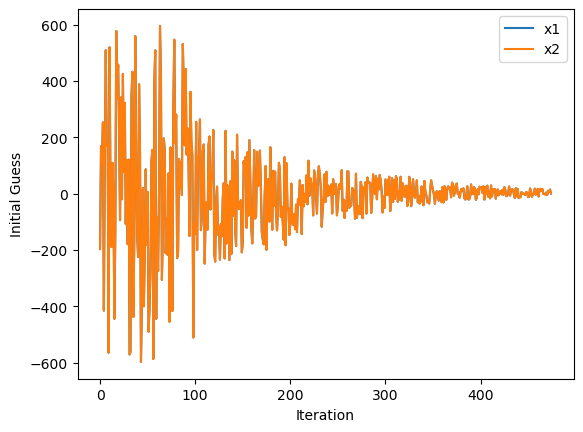

In [302]:
K_warmup2 = 100
x_star, initial_guesses = global_optimizer(griewank, bounds, K_warmup2, K_max, tolerance)

initial_guesses = np.array(initial_guesses)
plt.plot(initial_guesses[:, 1], label='x1')
plt.plot(initial_guesses[:, 1], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial Guess')
plt.legend()
plt.show()

The convergence is slower with a higher warm-up of K. The mystical Chi-oracle is doing a good job of narrowing down the convergence.